In [ ]:
%pip install prophet
%pip install mlflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
# Path to the saved tube and cycling data
tube_data_csv = 'tube_daily_data.csv'  
bus_data_csv = 'bus_daily_data.csv'  

if os.path.exists(tube_data_csv):
    tube_data = pd.read_csv(tube_data_csv, parse_dates=['Date'])
    print(f"Loaded existing tube with {len(tube_data)} rows.")
    
else:
    print("No existing tube data file found.")

if os.path.exists(bus_data_csv):
    bus_data = pd.read_csv(bus_data_csv, parse_dates=['Date'])
    print(f"Loaded existing bus with {len(bus_data)} rows.")
    
else:
    print("No existing bus data file found.")

Loaded existing tube with 1093 rows.
Loaded existing bus with 1093 rows.


In [4]:
print("Tube Data Info:")
print(tube_data.info())
print("\nTube Data Preview:")
print(tube_data.head())
print("\nBus Data Info:")
print(bus_data.info())  
print("\nBus Data Preview:")
print(bus_data.head())


Tube Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093 entries, 0 to 1092
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   1093 non-null   datetime64[ns]
 1   DayOfWeek              1093 non-null   object        
 2   TubeJourneyCount       1093 non-null   int64         
 3   TubeJourneyCount_lag1  1093 non-null   float64       
 4   t1                     1093 non-null   float64       
 5   t2                     1093 non-null   float64       
 6   hum                    1093 non-null   float64       
 7   wind_speed             1093 non-null   float64       
 8   weather                1093 non-null   object        
 9   is_holiday             1093 non-null   int64         
 10  is_weekend             1093 non-null   int64         
 11  season                 1093 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(4), ob

# EDA


### ---- For Tube Data ----


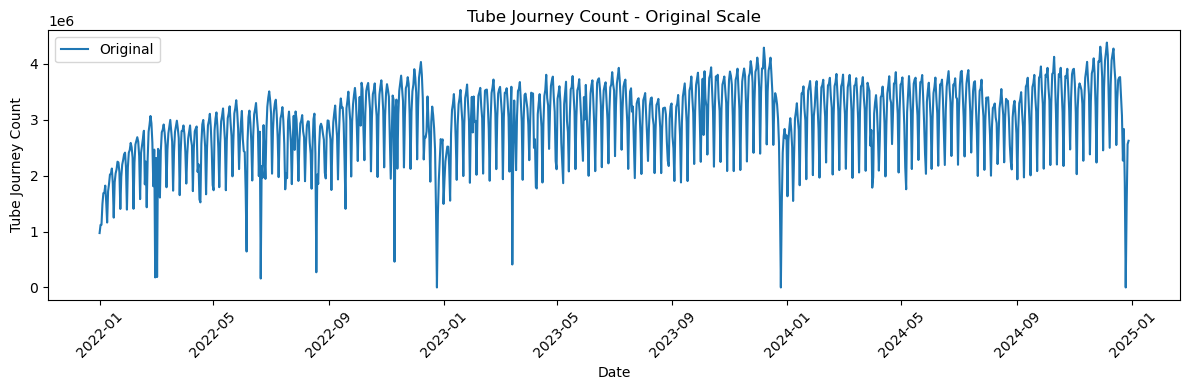

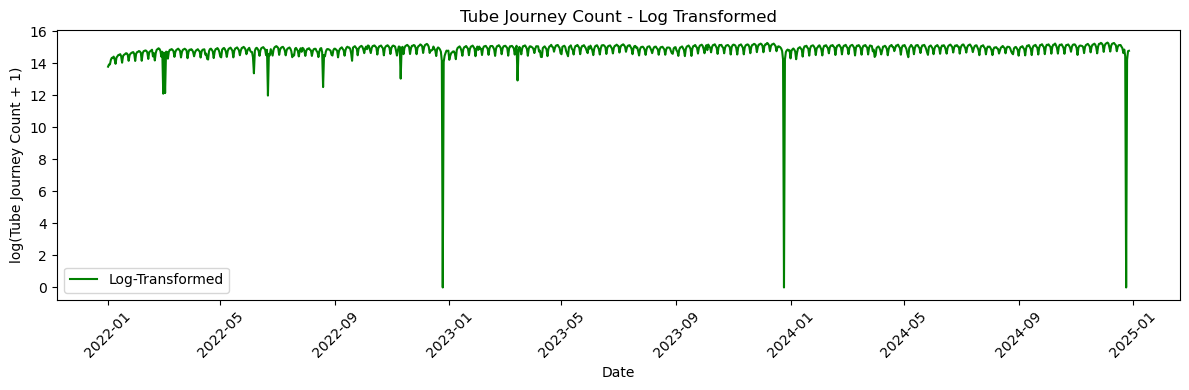

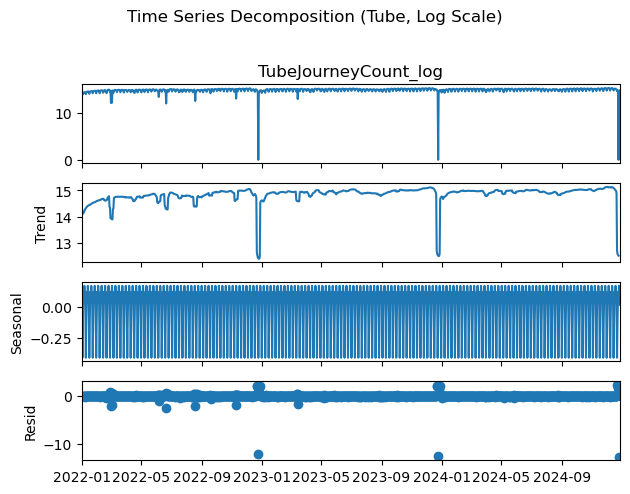

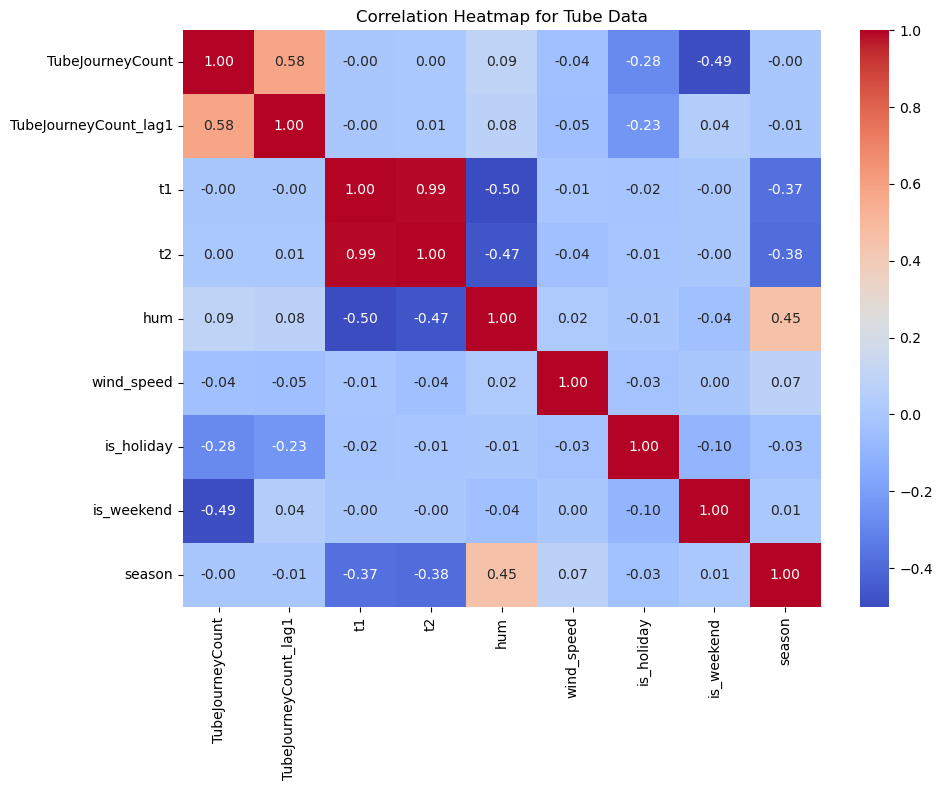

In [5]:
# Plot the original TubeJourneyCount series
plt.figure(figsize=(12, 4))
plt.plot(tube_data['Date'], tube_data['TubeJourneyCount'], label='Original')
plt.xlabel("Date")
plt.ylabel("Tube Journey Count")
plt.title("Tube Journey Count - Original Scale")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Log-transform the TubeJourneyCount to reduce scale and variability
tube_data['TubeJourneyCount_log'] = np.log(tube_data['TubeJourneyCount'] + 1)

plt.figure(figsize=(12, 4))
plt.plot(tube_data['Date'], tube_data['TubeJourneyCount_log'], label='Log-Transformed', color='green')
plt.xlabel("Date")
plt.ylabel("log(Tube Journey Count + 1)")
plt.title("Tube Journey Count - Log Transformed")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Time Series Decomposition of the log-transformed series (assuming daily data, use period=7 for weekly seasonality)
decomp = seasonal_decompose(tube_data.set_index('Date')['TubeJourneyCount_log'], model='additive', period=7)
decomp.plot()
plt.suptitle("Time Series Decomposition (Tube, Log Scale)", y=1.02)
plt.tight_layout()
plt.show()

# Correlation Analysis for Tube Data
# Consider the key features:
tube_features = ['TubeJourneyCount', 'TubeJourneyCount_lag1', 't1', 't2', 'hum', 'wind_speed', 'is_holiday', 'is_weekend', 'season']
tube_corr = tube_data[tube_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(tube_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap for Tube Data")
plt.tight_layout()
plt.show()



### ---- For Bus Data ----


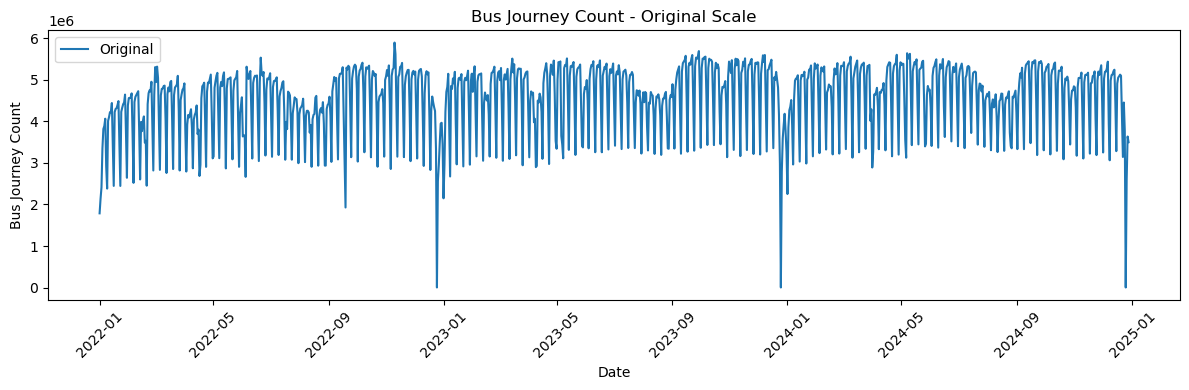

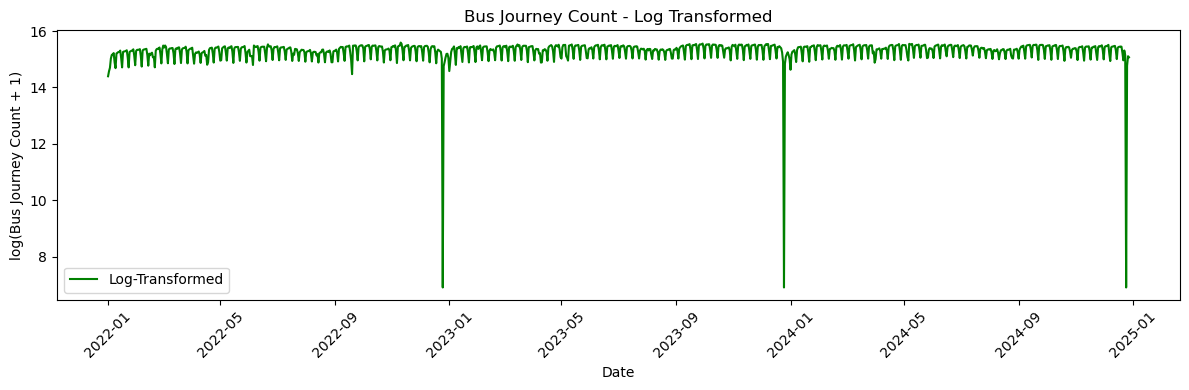

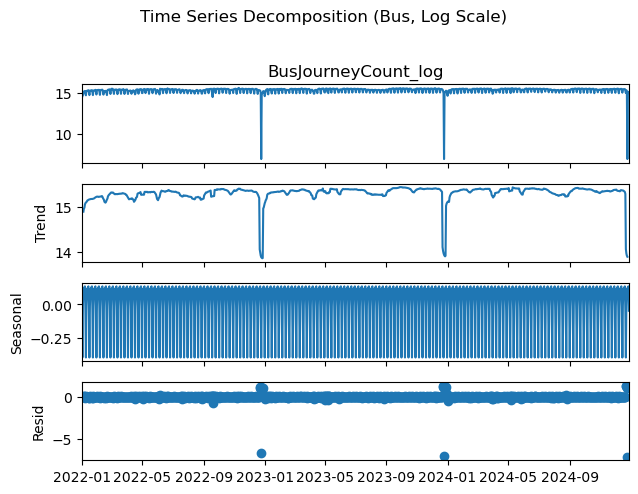

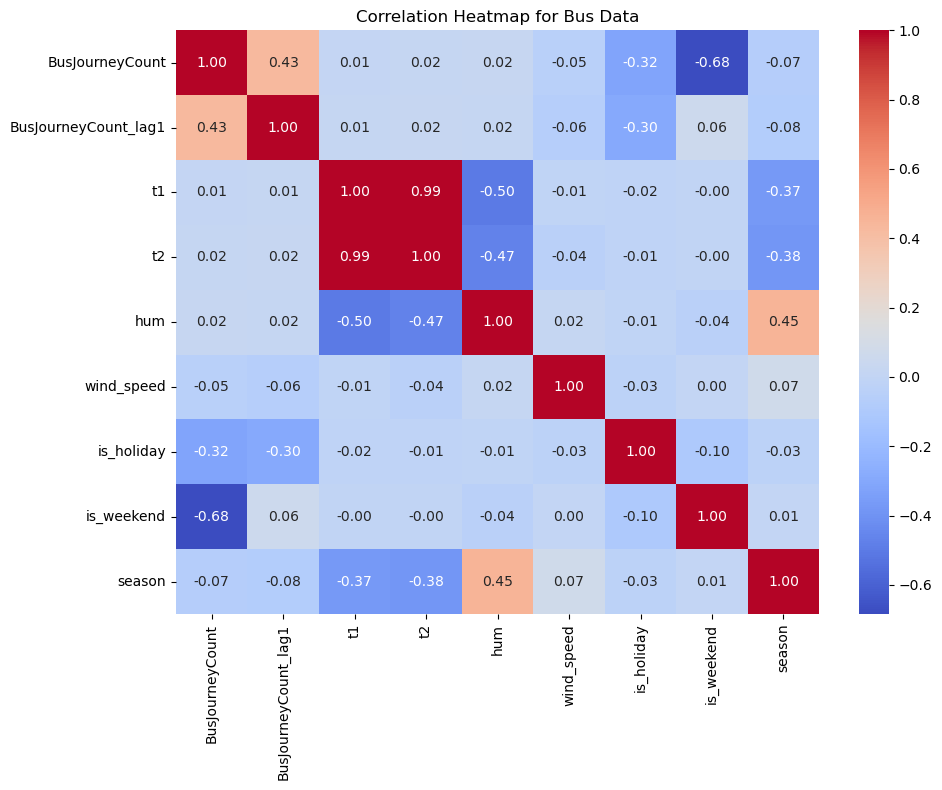

In [6]:
# Plot the original BusJourneyCount series
plt.figure(figsize=(12, 4))
plt.plot(bus_data['Date'], bus_data['BusJourneyCount'], label='Original')
plt.xlabel("Date")
plt.ylabel("Bus Journey Count")
plt.title("Bus Journey Count - Original Scale")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Log-transform BusJourneyCount
bus_data['BusJourneyCount_log'] = np.log(bus_data['BusJourneyCount'] + 1)

plt.figure(figsize=(12, 4))
plt.plot(bus_data['Date'], bus_data['BusJourneyCount_log'], label='Log-Transformed', color='green')
plt.xlabel("Date")
plt.ylabel("log(Bus Journey Count + 1)")
plt.title("Bus Journey Count - Log Transformed")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Time Series Decomposition of the log-transformed Bus data
decomp_bus = seasonal_decompose(bus_data.set_index('Date')['BusJourneyCount_log'], model='additive', period=7)
decomp_bus.plot()
plt.suptitle("Time Series Decomposition (Bus, Log Scale)", y=1.02)
plt.tight_layout()
plt.show()

# Correlation Analysis for Bus Data
bus_features = ['BusJourneyCount', 'BusJourneyCount_lag1', 't1', 't2', 'hum', 'wind_speed', 'is_holiday', 'is_weekend', 'season']
bus_corr = bus_data[bus_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(bus_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap for Bus Data")
plt.tight_layout()
plt.show()


# Forecasting Model for Tube (Raw Model)

### Prophet

02:27:02 - cmdstanpy - INFO - Chain [1] start processing
02:27:03 - cmdstanpy - INFO - Chain [1] done processing


Training period: 2022-01-01 00:00:00 to 2023-12-31 00:00:00
Testing period: 2024-01-01 00:00:00 to 2024-12-28 00:00:00


2025/04/16 02:27:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


NaNs in actual: 0
NaNs in forecast: 0
Min actual value: 0
NaN in ratios: 726
Inf in ratios: 0
Raw Model Error Metrics (Tube):
MAE (raw scale): 171236.9908174752
MSE (raw scale): 57589434951.01089
RMSE (raw scale): 239977.98847188233
MAPE (raw scale): 5.886012525483818 %
Percentage Error relative to mean actual count: 5.3539444757939085 %


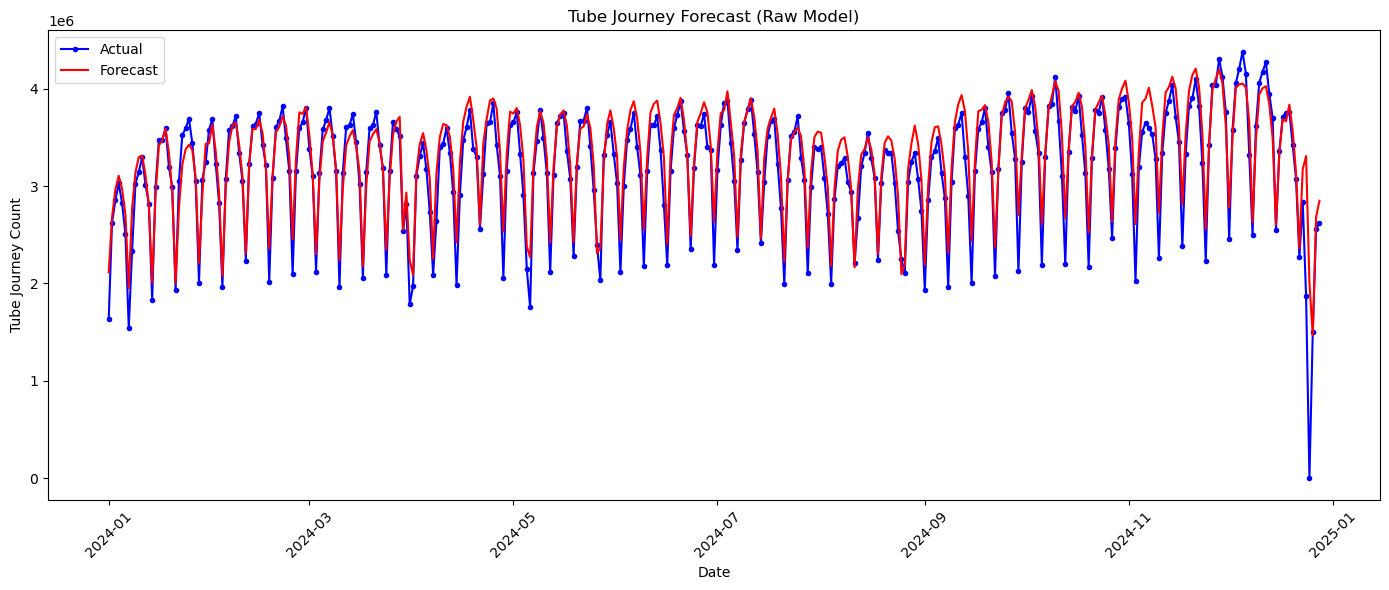

Model saved to tube_prophet_model.pkl


In [12]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import mlflow
import mlflow.prophet  # Import the Prophet module for MLflow

# Split the data into training and testing sets.
# We'll use all data before 2024-01-01 as training and from 2024-01-01 onward as testing.
train_tube = tube_data[tube_data['Date'] < '2024-01-01'].reset_index(drop=True)
test_tube = tube_data[tube_data['Date'] >= '2024-01-01'].reset_index(drop=True)

print("Training period:", train_tube['Date'].min(), "to", train_tube['Date'].max())
print("Testing period:", test_tube['Date'].min(), "to", test_tube['Date'].max())

# Prepare DataFrames for Prophet:
# Prophet requires the datetime column named 'ds' and target column 'y'
df_train_raw = train_tube.rename(columns={'Date': 'ds', 'TubeJourneyCount': 'y'})
df_test_raw = test_tube.rename(columns={'Date': 'ds', 'TubeJourneyCount': 'y'})

# Define the regressors to use:
regressor_cols = ['TubeJourneyCount_lag1', 't1', 'hum', 'wind_speed', 'is_holiday', 'is_weekend', 'season']

# Ensure regressor columns are numeric and fill missing values in training and testing sets.
for df in [df_train_raw, df_test_raw]:
    for col in regressor_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    # Fill missing values using forward-fill then backward-fill
    df[regressor_cols] = df[regressor_cols].ffill().bfill()

# ---------------------------
# Build and Fit Prophet Model (Raw Model)
# ---------------------------
# Initialize Prophet with no built-in seasonality; we'll add custom seasonalities.
model_raw = Prophet(
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=False
)
# Add custom seasonality: since data is daily, add weekly seasonality (period = 7)
model_raw.add_seasonality(name='weekly', period=7, fourier_order=5)
# Add yearly seasonality (if needed, period = 365.25 for daily data)
model_raw.add_seasonality(name='yearly', period=365.25, fourier_order=5)
# Add additional seasonalities if needed (e.g., monthly, quarterly)
model_raw.add_seasonality(name='monthly', period=30.5, fourier_order=3)


# Add each regressor
for reg in regressor_cols:
    model_raw.add_regressor(reg)

# Fit the model on training data
model_raw.fit(df_train_raw)

# ---------------------------
# Log Prophet Model to MLflow
# ---------------------------
mlflow.set_experiment("Transport_Forecasting_Deployment")
with mlflow.start_run(run_name="Final_Tube_Prophet_Model"):
    # Log model parameters
    mlflow.log_params({
        "regressor_features": regressor_cols,
        "train_start": train_tube['Date'].min().strftime('%Y-%m-%d'),
        "train_end": train_tube['Date'].max().strftime('%Y-%m-%d'),
        "seasonality_weekly_order": 5,
        "seasonality_yearly_order": 5,
        "seasonality_monthly_order": 3
    })
    
    # Log the model
    mlflow.prophet.log_model(model_raw, "tube_prophet_model")

# ---------------------------
# Forecasting
# ---------------------------
# Create a future DataFrame that covers the test period.
future_periods = len(df_test_raw)
future_raw = model_raw.make_future_dataframe(periods=future_periods, freq='D')
# Merge the regressors onto the future DataFrame using the complete available data.
full_df = pd.concat([df_train_raw, df_test_raw]).reset_index(drop=True)
future_raw = pd.merge(future_raw, full_df[['ds'] + regressor_cols], on='ds', how='left')
# Fill any missing regressor values in future period:
future_raw[regressor_cols] = future_raw[regressor_cols].ffill().bfill()

forecast_raw = model_raw.predict(future_raw)
# Restrict the forecast to the test period.
forecast_test_raw = forecast_raw[forecast_raw['ds'] >= df_test_raw['ds'].min()].copy()

print("NaNs in actual:", df_test_raw['y'].isna().sum())
print("NaNs in forecast:", forecast_test_raw['yhat'].isna().sum())

# ---------------------------
# Error Metrics Calculation
# ---------------------------
# Compute standard error metrics on the raw scale.
mae_raw = mean_absolute_error(df_test_raw['y'], forecast_test_raw['yhat'])
mse_raw = mean_squared_error(df_test_raw['y'], forecast_test_raw['yhat'])
rmse_raw = np.sqrt(mse_raw)
# Calculate MAPE (Mean Absolute Percentage Error) -- avoid division by zero using epsilon.
epsilon = 1e-8
# mape_raw = np.mean(np.abs((df_test_raw['y'] - forecast_test_raw['yhat']) / (df_test_raw['y'] + epsilon))) * 100
# Debug calculations
diffs = np.abs(df_test_raw['y'] - forecast_test_raw['yhat'])
divisors = df_test_raw['y'] + epsilon
ratios = diffs / divisors
print("Min actual value:", np.min(df_test_raw['y']))
print("NaN in ratios:", np.isnan(ratios).sum())
print("Inf in ratios:", np.isinf(ratios).sum())
# Only include points where actual values are above 0
# Realign the forecast and actual data for MAPE calculation by date key
df_combined = pd.merge(
    df_test_raw.reset_index()[['ds', 'y']], 
    forecast_test_raw[['ds', 'yhat']], 
    on='ds'
)
mask = df_combined['y'] > 0
if mask.sum() > 0:  # Make sure we have data points left
    mape_raw = np.mean(np.abs((df_combined['y'][mask] - df_combined['yhat'][mask]) / 
                             (df_combined['y'][mask] + epsilon))) * 100
else:
    mape_raw = np.nan  # Still no valid points

print("Raw Model Error Metrics (Tube):")
print("MAE (raw scale):", mae_raw)
print("MSE (raw scale):", mse_raw)
print("RMSE (raw scale):", rmse_raw)
print("MAPE (raw scale):", mape_raw, "%")

# ---------------------------
# Additional: Convert predictions to the original count scale (if desired)
# ---------------------------

baseline = df_test_raw['y'].mean()
percentage_error = (mae_raw / baseline) * 100
print("Percentage Error relative to mean actual count:", percentage_error, "%")

# ---------------------------
# Visualize the Forecast vs. Actual (Tube, Raw Model)
# ---------------------------
plt.figure(figsize=(14,6))
plt.plot(df_test_raw['ds'], df_test_raw['y'], 'bo-', markersize=3, label='Actual')
plt.plot(forecast_test_raw['ds'], forecast_test_raw['yhat'], 'r-', markersize=3, label='Forecast')
plt.xlabel("Date")
plt.ylabel("Tube Journey Count")
plt.title("Tube Journey Forecast (Raw Model)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Log the metrics to MLflow
with mlflow.start_run(run_name="Final_Tube_Prophet_Metrics"):
    mlflow.log_metrics({
        "MAE": mae_raw,
        "MSE": mse_raw,
        "RMSE": rmse_raw,
        "MAPE": mape_raw,
        "Percentage_Error_Mean": percentage_error
    })

# ---------------------------
# Save the model as a pickle file
# ---------------------------
import pickle

# Define the file path where you want to save the model
pickle_file_path = 'tube_prophet_model.pkl'

# Save the model
with open(pickle_file_path, 'wb') as file:
    pickle.dump(model_raw, file)

print(f"Model saved to {pickle_file_path}")

### SARIMAX

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
import mlflow
import mlflow.statsmodels  # This will help us log the model if needed
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Set up MLflow Experiment ---
mlflow.set_experiment("Tube_Journey_SARIMAX_Forecasting")

# Define a function for safe MAPE calculation
def safe_mape(actual, forecast, epsilon=1e-8):
    # Create a DataFrame aligned on the date key if needed
    # Here actual and forecast are assumed to be numpy arrays of same length
    mask = actual > 0
    if mask.sum() > 0:
        mape_val = np.mean(np.abs((actual[mask] - forecast[mask]) / (actual[mask] + epsilon))) * 100
    else:
        mape_val = np.nan
    return mape_val

# ---------------------------
# Prepare the Tube Data for SARIMAX
# ---------------------------


# Set Date as index for statsmodels.
tube_data = tube_data.sort_values('Date').reset_index(drop=True)
tube_data.set_index('Date', inplace=True)

# Split the data into training and testing sets.
train_tube = tube_data[ tube_data.index < '2024-01-01' ].copy()
test_tube  = tube_data[ tube_data.index >= '2024-01-01' ].copy()

print("Training period:", train_tube.index.min(), "to", train_tube.index.max())
print("Testing period:", test_tube.index.min(), "to", test_tube.index.max())

# Define the target variable (endog) and exogenous regressors (exog)
# Our target is TubeJourneyCount (raw count)
endog_train = train_tube['TubeJourneyCount']
endog_test = test_tube['TubeJourneyCount']

exog_cols = ['TubeJourneyCount_lag1', 't1', 'hum', 'wind_speed', 'is_holiday', 'is_weekend', 'season']
exog_train = train_tube[exog_cols].astype(float).ffill().bfill()
exog_test = test_tube[exog_cols].astype(float).ffill().bfill()

# ---------------------------
# SARIMAX Model Setup and Fitting using MLflow for tracking
# ---------------------------
with mlflow.start_run(run_name="Tube_SARIMAX_Raw_Model"):

    # Log basic parameters
    sarimax_order = (1, 1, 1)
    seasonal_order = (1, 0, 0, 7)  # weekly seasonality
    mlflow.log_param("order", sarimax_order)
    mlflow.log_param("seasonal_order", seasonal_order)
    mlflow.log_param("exog_features", exog_cols)
    
    # Fit the SARIMAX model with exogenous regressors
    model_sarimax = SARIMAX(endog_train, exog=exog_train, order=sarimax_order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    results = model_sarimax.fit(disp=False)
    
    # Forecast for the test period
    forecast_results = results.get_forecast(steps=len(test_tube), exog=exog_test)
    forecast_values = forecast_results.predicted_mean
    conf_int = forecast_results.conf_int()
    
    # Calculate error metrics on the raw scale
    mae_val = mean_absolute_error(endog_test, forecast_values)
    mse_val = mean_squared_error(endog_test, forecast_values)
    rmse_val = np.sqrt(mse_val)
    mape_val = safe_mape(endog_test.values, forecast_values.values)
    
    # Log metrics into MLflow
    mlflow.log_metric("MAE_raw", mae_val)
    mlflow.log_metric("MSE_raw", mse_val)
    mlflow.log_metric("RMSE_raw", rmse_val)
    mlflow.log_metric("MAPE_raw", mape_val)
    
    print("SARIMAX Model Error Metrics (Tube - Raw):")
    print("MAE (raw scale):", mae_val)
    print("MSE (raw scale):", mse_val)
    print("RMSE (raw scale):", rmse_val)
    print("MAPE (raw scale):", mape_val, "%")
    
    # Optionally log the SARIMAX model (mlflow.statsmodels can log statsmodels results)
    mlflow.statsmodels.log_model(results, "sarimax_model")

# ---------------------------
# Visualization of Forecast vs. Actual
# ---------------------------
# Create a DataFrame to compare forecast with actual values
forecast_df = pd.DataFrame({
    "ds": test_tube.index,
    "Actual": endog_test,
    "Forecast": forecast_values
})

plt.figure(figsize=(14, 6))
plt.plot(forecast_df["ds"], forecast_df["Actual"], "bo-", markersize=3, label="Actual")
plt.plot(forecast_df["ds"], forecast_df["Forecast"], "r-", markersize=3, label="Forecast")
plt.xlabel("Date")
plt.ylabel("Tube Journey Count")
plt.title("Tube Journey Forecast using SARIMAX (Raw Model)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### XGBoost

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best Negative MAPE Score: -15.97831934026325
Tuned XGBoost Model Error Metrics (Tube):
MAE: 264880.87982093665
MSE: 105675320198.41663
RMSE: 325077.40647177654
MAPE: 8.75655114404977 %
Percentage Error relative to mean actual count: 8.281840953234079 %


C:\Users\gupta\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [20:52:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/04/15 20:52:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


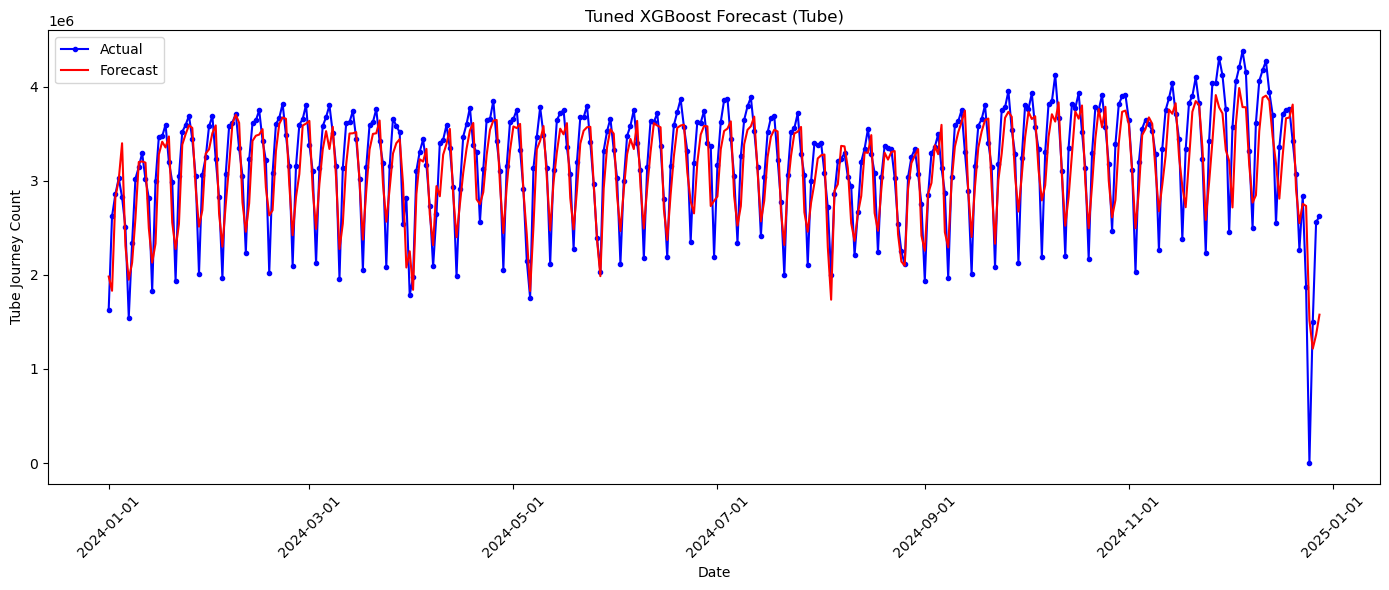

In [10]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
import mlflow
import mlflow.xgboost

# Define a custom MAPE scoring function that safely excludes cases where the actual value is zero.
def safe_mape(y_true, y_pred, epsilon=1e-8):
    mask = y_true > 0
    if mask.sum() > 0:
        return np.mean(np.abs((y_true[mask] - y_pred[mask]) / (y_true[mask] + epsilon))) * 100
    else:
        return np.nan

mape_scorer = make_scorer(safe_mape, greater_is_better=False)

# ---------------------------
# Prepare Data for Tuning (using the same tube_data as before)
# ---------------------------

# Define features and target.
features = ['TubeJourneyCount_lag1', 't1', 'hum', 'wind_speed', 'is_holiday', 'is_weekend', 'season']
target = 'TubeJourneyCount'

X_train = train_tube[features].astype(float).ffill().bfill()
y_train = train_tube[target].astype(float)
X_test = test_tube[features].astype(float).ffill().bfill()
y_test = test_tube[target].astype(float)

# ---------------------------
# Set up GridSearchCV with a time series split
# ---------------------------
# Create a parameter grid to search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Set up a time series split (e.g., 3 splits)
tscv = TimeSeriesSplit(n_splits=3)

# Create XGBoost regressor
xgb_reg = xgb.XGBRegressor(random_state=42)

# We use negative MAPE as the scoring function (since lower MAPE is better).
grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring=mape_scorer,
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

# Run grid search
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Negative MAPE Score:", grid_search.best_score_)  # This is negative; lower is better

# Get the best estimator
best_xgb = grid_search.best_estimator_

# Predict on the test set with the best model
y_pred = best_xgb.predict(X_test)

# Calculate error metrics on the test set
mae_xgb = mean_absolute_error(y_test, y_pred)
mse_xgb = mean_squared_error(y_test, y_pred)
rmse_xgb = np.sqrt(mse_xgb)
mape_xgb = safe_mape(y_test.values, y_pred)

print("Tuned XGBoost Model Error Metrics (Tube):")
print("MAE:", mae_xgb)
print("MSE:", mse_xgb)
print("RMSE:", rmse_xgb)
print("MAPE:", mape_xgb, "%")

baseline = np.mean(y_test)
percentage_error = (mae_xgb / baseline) * 100
print("Percentage Error relative to mean actual count:", percentage_error, "%")

# Log the tuned model and parameters to MLflow
mlflow.set_experiment("Tube_Journey_XGBoost_Tuning")
with mlflow.start_run(run_name="Tube_XGBoost_Tuned_Model"):
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metric("MAE", mae_xgb)
    mlflow.log_metric("MSE", mse_xgb)
    mlflow.log_metric("RMSE", rmse_xgb)
    mlflow.log_metric("MAPE", mape_xgb)
    mlflow.log_metric("Percentage_Error_mean", percentage_error)
    mlflow.xgboost.log_model(best_xgb, "best_xgb_model")

# Visualize the predictions
import matplotlib.dates as mdates

plt.figure(figsize=(14,6))
plt.plot(test_tube.index, y_test, "bo-", markersize=3, label="Actual")
plt.plot(test_tube.index, y_pred, "r-", markersize=3, label="Forecast")
plt.xlabel("Date")
plt.ylabel("Tube Journey Count")
plt.title("Tuned XGBoost Forecast (Tube)")
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.tight_layout()
plt.show()


LSTM

Shape of X: (1086, 7, 7)
Shape of y: (1086,)
Training samples: 723
Testing samples: 363


C:\Users\gupta\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 50)             │        11,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,651 (45.51 KB)

 Trainable params: 11,651 (45.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3638044655616.0000 - val_loss: 476074082304.0000
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1109183037440.0000 - val_loss: 586145595392.0000
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 837451251712.0000 - val_loss: 583839645696.0000
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 797012459520.0000 - val_loss: 610562473984.0000
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 754973278208.0000 - val_loss: 571219247104.0000
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 674579742720.0000 - val_loss: 570781663232.0000
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 747502960640.0000 - val_loss: 509655384064.0000
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 621049479168.0000 - val_loss: 445915529216.0000
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 512171835392.0000 - val_loss: 415471435776.0000
Epoch 10/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

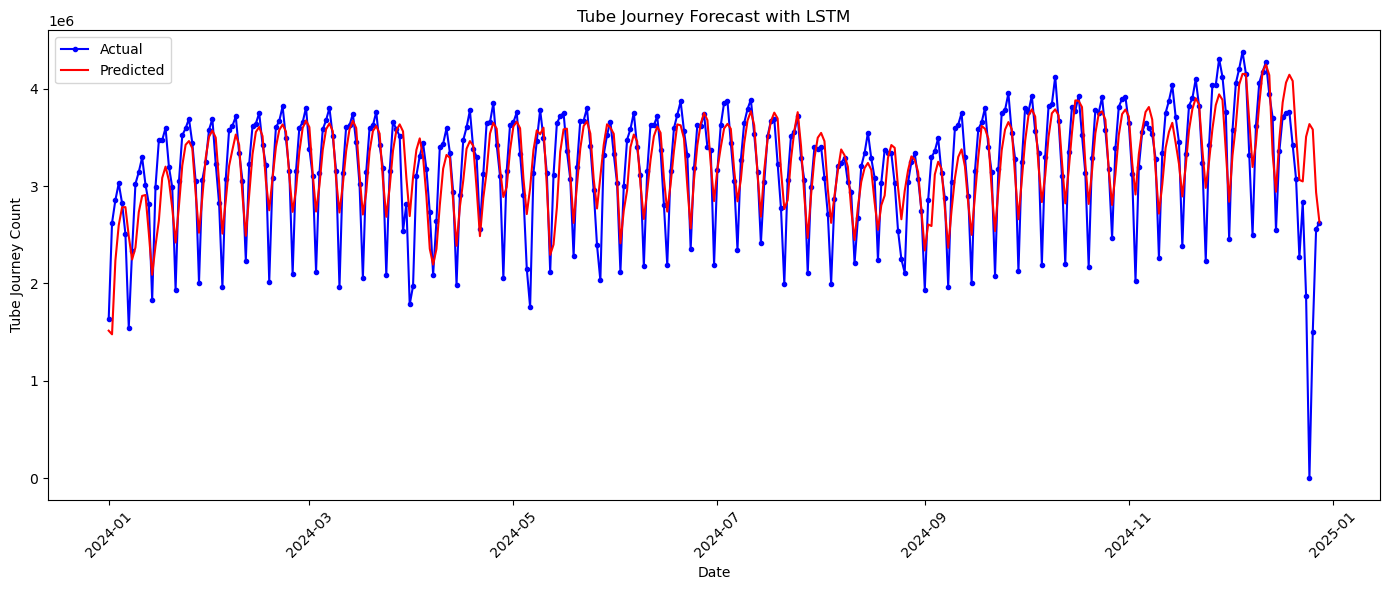

In [17]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# ---- Data Preparation ----
# Assuming tube_data is already available from Phase 2 and has Date as the index.
# Reset the index so that Date becomes a column.
tube_data_reset = tube_data.reset_index()  # 'Date' column is now available

# Define feature columns (we dropped t2 and weather_code as per our decision)
feature_cols = ['TubeJourneyCount_lag1', 't1', 'hum', 'wind_speed', 'is_holiday', 'is_weekend', 'season']
target_col = 'TubeJourneyCount'

# Create a supervised learning dataset using a sliding window approach.
def create_dataset(df, window_size, feature_cols, target_col):
    X, y, dates = [], [], []
    for i in range(len(df) - window_size):
        # For each sample, we use a window of consecutive days of the selected features.
        X.append(df[feature_cols].iloc[i:i+window_size].values)
        # The target is the tube journey count on the day following the window.
        y.append(df[target_col].iloc[i+window_size])
        # Also record the date for the target (for plotting/alignment)
        dates.append(df['Date'].iloc[i+window_size])
    return np.array(X), np.array(y), np.array(dates)

window_size = 7  # 7-day window
X, y, date_array = create_dataset(tube_data_reset, window_size, feature_cols, target_col)
print("Shape of X:", X.shape)  # (samples, window_size, number of features)
print("Shape of y:", y.shape)

# ---- Split into Training and Testing Sets ----
# We use a cutoff date of 2024-01-01
train_mask = date_array < pd.Timestamp('2024-01-01')
X_train = X[train_mask]
y_train = y[train_mask]
dates_train = date_array[train_mask]

X_test = X[~train_mask]
y_test = y[~train_mask]
dates_test = date_array[~train_mask]

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

# ---- Neural Network Model (LSTM) ----
# Build a simple LSTM model.
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(window_size, len(feature_cols))))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

# Train the model.
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

# ---- Predictions and Error Metrics ----
y_pred = model.predict(X_test).flatten()

# Calculate error metrics.
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Safe MAPE calculation: ignore cases where actual is zero.
epsilon = 1e-8
mask = y_test > 0
if mask.sum() > 0:
    mape = np.mean(np.abs((y_test[mask] - y_pred[mask]) / (y_test[mask] + epsilon))) * 100
else:
    mape = np.nan

print("LSTM Model Error Metrics (Tube):")
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("MAPE:", mape, "%")

# Visualize predictions vs. actual values.
plt.figure(figsize=(14, 6))
plt.plot(dates_test, y_test, 'bo-', markersize=3, label="Actual")
plt.plot(dates_test, y_pred, 'r-', markersize=3, label="Predicted")
plt.xlabel("Date")
plt.ylabel("Tube Journey Count")
plt.title("Tube Journey Forecast with LSTM")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [20]:
%pip install keras_tuner


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


TFT KEras

In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.layers import MultiHeadAttention
import keras_tuner as kt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ---------------------------
# Define a Transformer Encoder Block
# ---------------------------
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout_rate):
    # Layer normalization and multi-head attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout_rate)(x, x)
    x = Dropout(dropout_rate)(x)
    res = x + inputs

    # Feed Forward network
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

# ---------------------------
# Define the Model Builder for the Simplified TFT
# ---------------------------
def build_tft_model(hp):
    window_size = X_train.shape[1]  # e.g., 7 days
    num_features = X_train.shape[2]  # number of exogenous features
    inputs = Input(shape=(window_size, num_features))
    x = inputs
    # Tune the number of transformer blocks (1 to 3)
    num_transformer_blocks = hp.Int("num_transformer_blocks", min_value=1, max_value=3, step=1)
    for i in range(num_transformer_blocks):
        head_size = hp.Int("head_size", min_value=32, max_value=64, step=16)
        num_heads = hp.Int("num_heads", min_value=2, max_value=4, step=1)
        ff_dim = hp.Int("ff_dim", min_value=64, max_value=128, step=32)
        dropout_rate = hp.Float("dropout_rate", min_value=0.1, max_value=0.3, step=0.1)
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout_rate)
    
    # Global average pooling over the time dimension
    x = GlobalAveragePooling1D()(x)
    
    # MLP layers for final prediction
    # Tune the MLP layer dimensions using string identifiers
    mlp_config = hp.Choice("mlp_config", values=["config1", "config2", "config3"])
    
    # Map string identifier to actual configurations
    if mlp_config == "config1":
        mlp_units = [64]
    elif mlp_config == "config2":
        mlp_units = [64, 32]
    else:  # config3
        mlp_units = [128, 64]
    
    for units in mlp_units:
        x = Dense(units, activation="relu")(x)
        x = Dropout(hp.Float("mlp_dropout", 0.1, 0.3, step=0.1))(x)
    
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    # Tune the learning rate (using a log space)
    lr = hp.Float("learning_rate", 1e-4, 1e-3, sampling="log")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss="mse")
    return model

# ---------------------------
# Setup Keras Tuner with Hyperband
# ---------------------------
tft_tuner = kt.Hyperband(
    build_tft_model,
    objective="val_loss",
    max_epochs=50,
    factor=3,
    directory="kt_tft_experiments",
    project_name="tube_tft"
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Run the tuner search
tft_tuner.search(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, callbacks=[early_stop], verbose=1)

# Get the best model and hyperparameters
best_tft_model = tft_tuner.get_best_models(num_models=1)[0]
best_hp = tft_tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters for TFT Model:")
print(best_hp.values)

# ---------------------------
# Evaluate the Best Model on Test Set
# ---------------------------
y_pred_tft = best_tft_model.predict(X_test).flatten()

mae_tft = mean_absolute_error(y_test, y_pred_tft)
mse_tft = mean_squared_error(y_test, y_pred_tft)
rmse_tft = np.sqrt(mse_tft)
epsilon = 1e-8
mask = y_test > 0
if mask.sum() > 0:
    mape_tft = np.mean(np.abs((y_test[mask] - y_pred_tft[mask]) / (y_test[mask] + epsilon))) * 100
else:
    mape_tft = np.nan

print("Transformer (TFT) Model Error Metrics (Tube):")
print("MAE:", mae_tft)
print("MSE:", mse_tft)
print("RMSE:", rmse_tft)
print("MAPE:", mape_tft, "%")


Trial 90 Complete [00h 00m 17s]
val_loss: 477827203072.0

Best val_loss So Far: 476752445440.0
Total elapsed time: 00h 25m 39s
Best Hyperparameters for TFT Model:
{'num_transformer_blocks': 2, 'head_size': 32, 'num_heads': 2, 'ff_dim': 128, 'dropout_rate': 0.1, 'mlp_config': 'config1', 'mlp_dropout': 0.1, 'learning_rate': 0.0005065981369853531, 'tuner/epochs': 17, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Transformer (TFT) Model Error Metrics (Tube):
MAE: 459676.81095041323
MSE: 338895010466.8084
RMSE: 582146.8976700025
MAPE: 16.02542121376082 %


### Prophet for bus data


02:27:21 - cmdstanpy - INFO - Chain [1] start processing
02:27:21 - cmdstanpy - INFO - Chain [1] done processing


Bus Data Training period: 2022-01-01 00:00:00 to 2023-12-31 00:00:00
Bus Data Testing period: 2024-01-01 00:00:00 to 2024-12-28 00:00:00


2025/04/16 02:27:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


sMAPE for Bus: 4.6314334751978565 %
Prophet Bus Model Error Metrics:
MAE (raw scale): 192138.8033235193
MSE (raw scale): 81238359146.01321
RMSE (raw scale): 285023.43613466807
Symmetric MAPE (raw scale): 4.6314334751978565 %
Percentage Error relative to mean actual count: 4.110163124854516 %


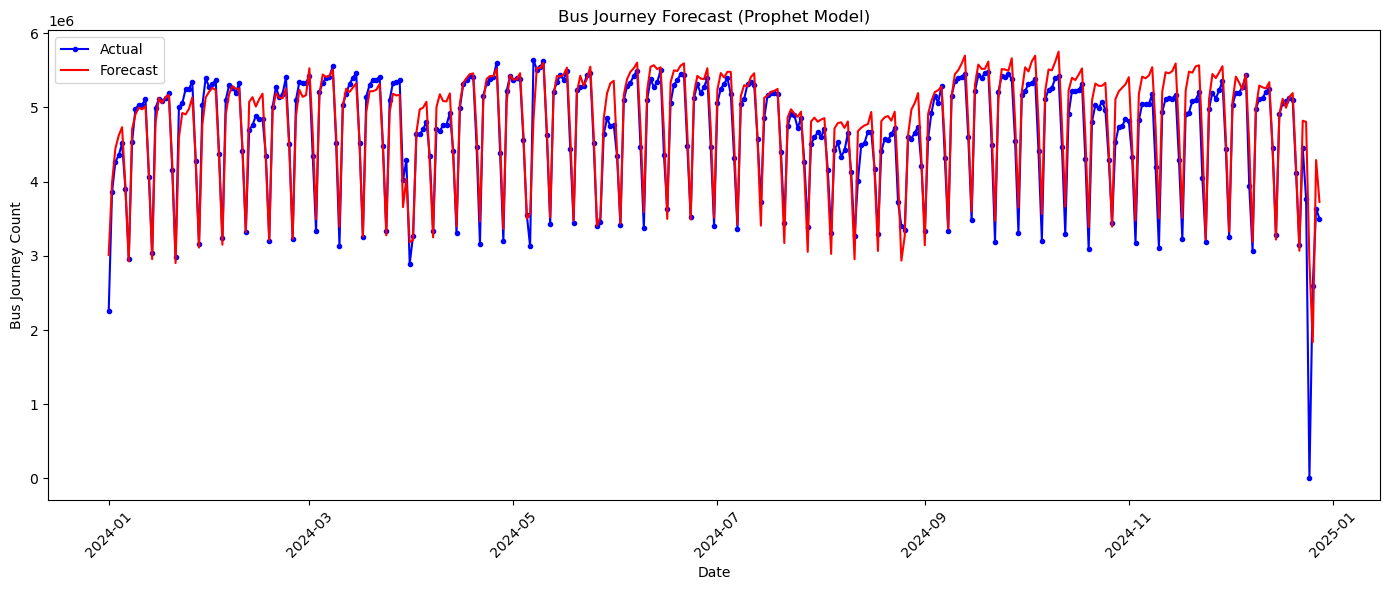

Model saved to bus_prophet_model.pkl


In [13]:
# Split the bus data into training and testing sets using a cutoff.
train_bus = bus_data[bus_data['Date'] < '2024-01-01'].reset_index(drop=True)
test_bus = bus_data[bus_data['Date'] >= '2024-01-01'].reset_index(drop=True)

print("Bus Data Training period:", train_bus['Date'].min(), "to", train_bus['Date'].max())
print("Bus Data Testing period:", test_bus['Date'].min(), "to", test_bus['Date'].max())

# Prepare DataFrames for Prophet
# Prophet requires the datetime column to be named 'ds' and target to be 'y'.
df_train_bus = train_bus.rename(columns={'Date': 'ds', 'BusJourneyCount': 'y'})
df_test_bus = test_bus.rename(columns={'Date': 'ds', 'BusJourneyCount': 'y'})

# Define regressors for Bus model:
regressor_cols_bus = ['BusJourneyCount_lag1', 't1', 'hum', 'wind_speed', 'is_holiday', 'is_weekend', 'season']

# Ensure the regressor columns are numeric and fill missing values
for df in [df_train_bus, df_test_bus]:
    for col in regressor_cols_bus:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df[regressor_cols_bus] = df[regressor_cols_bus].ffill().bfill()

# Initialize Prophet and add seasonalities
model_bus = Prophet(
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=False
)

# Add custom seasonality:
model_bus.add_seasonality(name='weekly', period=7, fourier_order=5)
model_bus.add_seasonality(name='yearly', period=365.25, fourier_order=5)
model_bus.add_seasonality(name='monthly', period=30.5, fourier_order=3)

# Add regressors
for reg in regressor_cols_bus:
    model_bus.add_regressor(reg)

# Fit the model on training data
model_bus.fit(df_train_bus)

# ---------------------------
# Log Prophet Model to MLflow
# ---------------------------
mlflow.set_experiment("Transport_Forecasting_Deployment")
with mlflow.start_run(run_name="Final_Bus_Prophet_Model"):
    # Log model parameters
    mlflow.log_params({
        "regressor_features": regressor_cols_bus,
        "train_start": train_bus['Date'].min().strftime('%Y-%m-%d'),
        "train_end": train_bus['Date'].max().strftime('%Y-%m-%d'),
        "seasonality_weekly_order": 5,
        "seasonality_yearly_order": 5,
        "seasonality_monthly_order": 3
    })
    
    # Log the model
    mlflow.prophet.log_model(model_bus, "bus_prophet_model")

# Forecast for the test period
future_bus = model_bus.make_future_dataframe(periods=len(df_test_bus), freq='D')
# Merge regressor values into the future DataFrame
full_bus = pd.concat([df_train_bus, df_test_bus]).reset_index(drop=True)
future_bus = pd.merge(future_bus, full_bus[['ds'] + regressor_cols_bus], on='ds', how='left')
future_bus[regressor_cols_bus] = future_bus[regressor_cols_bus].ffill().bfill()

forecast_bus = model_bus.predict(future_bus)
# Filter forecast for the test period
forecast_test_bus = forecast_bus[forecast_bus['ds'] >= df_test_bus['ds'].min()].copy()

# Calculate error metrics on test set for Bus model
mae_bus = mean_absolute_error(df_test_bus['y'], forecast_test_bus['yhat'])
mse_bus = mean_squared_error(df_test_bus['y'], forecast_test_bus['yhat'])
rmse_bus = np.sqrt(mse_bus)

epsilon = 1e-8
# Align forecast and actual data by merging on the date key
df_combined_bus = pd.merge(
    df_test_bus.reset_index()[['ds', 'y']], 
    forecast_test_bus[['ds', 'yhat']], 
    on='ds'
)
mask_bus = df_combined_bus['y'] > 0

def smape(actual, pred, epsilon=1e-8):
    return np.mean(2 * np.abs(actual - pred) / (np.abs(actual) + np.abs(pred) + epsilon)) * 100

# Assuming df_combined_bus is as defined:
smape_bus = smape(df_combined_bus['y'].values, df_combined_bus['yhat'].values)
print("sMAPE for Bus:", smape_bus, "%")

print("Prophet Bus Model Error Metrics:")
print("MAE (raw scale):", mae_bus)
print("MSE (raw scale):", mse_bus)
print("RMSE (raw scale):", rmse_bus)
print("Symmetric MAPE (raw scale):", smape_bus, "%")

# ---------------------------
# Additional: Convert predictions to the original count scale (if desired)
# ---------------------------

baseline = df_test_bus['y'].mean()
percentage_error = (mae_bus / baseline) * 100
print("Percentage Error relative to mean actual count:", percentage_error, "%")

# Visualize Forecast vs. Actual for Bus Data
plt.figure(figsize=(14,6))
plt.plot(df_test_bus['ds'], df_test_bus['y'], 'bo-', markersize=3, label="Actual")
plt.plot(forecast_test_bus['ds'], forecast_test_bus['yhat'], 'r-', markersize=3, label="Forecast")
plt.xlabel("Date")
plt.ylabel("Bus Journey Count")
plt.title("Bus Journey Forecast (Prophet Model)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Log metrics to MLflow
with mlflow.start_run(run_name="Final_Bus_Prophet_Metrics"):
    mlflow.log_metrics({
        "MAE": mae_bus,
        "MSE": mse_bus,
        "RMSE": rmse_bus,
        "sMAPE": smape_bus,
        "Percentage_Error_Mean": percentage_error
    })
    
# ---------------------------
# Save the model as a pickle file
# ---------------------------
import pickle

# Define the file path where you want to save the model
pickle_file_path = 'bus_prophet_model.pkl'

# Save the model
with open(pickle_file_path, 'wb') as file:
    pickle.dump(model_raw, file)

print(f"Model saved to {pickle_file_path}")